This is for h5 to SavedModel conversion then, make it ONNX 32bit

In [1]:
# To ignore warinings, since kaggle notebook shows some debug info
import os, tarfile
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
print(tf.__version__)
import cv2
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import keras
import numpy as np
import math
from keras import layers
from keras import regularizers
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Conv2DTranspose, Concatenate,Activation,BatchNormalization,Dropout
import tensorflow.keras.backend as K


def imresize(array,shape):
    resized_images = np.empty((array.shape[0], shape, shape), dtype=array.dtype)
    for i in range(array.shape[0]):
        # Extract the current image
        current_image = array[i, :, :]  # Assuming the channel axis is the last one
        # Resize the image using cv2.resize
        resized_image = cv2.resize(current_image, (shape, shape), interpolation=cv2.INTER_LINEAR)
        # Add the resized image to the new array
        resized_images[i, :, :] = resized_image

    return resized_images

import os, tarfile

data_size = 960
#x_train = np.load(f'./datasets/Training{data_size}.npy')
x_test = np.load(f'./Validation{data_size}_half.npy')

output_size=640,640
resize=1
if resize:
    shape=output_size[0]
    #x_train=imresize(x_train,shape)
    x_test=imresize(x_test,shape)
x_test=tf.image.convert_image_dtype(x_test,dtype='bfloat16')


#plt.imshow(tf.cast(x_test[0],dtype='float32'))
#x_train = tf.expand_dims(x_train, axis=-1)#make them NHWC
x_test = tf.expand_dims(x_test, axis=-1)
#confirm they are idential except N
#print(x_train.shape)
print(x_test.shape)
#print(x_train.dtype)
print(x_test.dtype)

def PropagationLayer(input,mode=None):#Angular spectrum method for input or output
    input=tf.cast(input,dtype='float32')#estimated POH itself
    inputs=Input((output_size[0],output_size[1],1))
    input=tf.squeeze(input, axis=-1)#to eliminate calculation error in ASM
    lamda = 532e-9 #lambda is the reserved word
    dp = 8e-6 #pixel size of SLM you use
    z = 100e-3 #propagation distance you assume
    pad_m = inputs.shape[1] // 2
    pad_n = inputs.shape[2] // 2
    if mode=="input":
        padded_real = tf.math.cos(input)
        padded_imaginary = tf.math.sin(input)
        z = -z #propagation distance,bu reverse direction
    else: #input is 0 to 1 data by sigmoid
        padded_real = tf.math.cos(2*math.pi*input)
        padded_imaginary = tf.math.sin(2*math.pi*input)
    inputsc = tf.complex(padded_real, padded_imaginary)#complex amp of POH, same as exp(1j*...)
    Lx = dp * inputs.shape[2]
    Ly = dp * inputs.shape[1]
    f_max = 0.5 / dp
    du = 1.0 / Lx
    dv = 1.0 / Ly
    x_range = tf.range(-f_max, f_max, du, dtype=tf.float32)
    y_range = tf.range(-f_max, f_max, dv, dtype=tf.float32)
    fx, fy = tf.meshgrid(x_range, y_range)
    FH = tf.signal.fftshift(tf.signal.ifft2d(tf.signal.fftshift(inputsc)))
    real_part = tf.math.cos(2 * math.pi * z * tf.sqrt(1 /(lamda**2) - fx**2 - fy**2))
    imaginary_part = tf.math.sin(2 * math.pi * z * tf.sqrt(1 /(lamda**2) - fx**2 - fy**2))
    P = tf.complex(real_part, imaginary_part)#normal ASM kernel
    #define frequency limit for sampling theorem
    fx_max = tf.math.divide(inputs.shape[1] * dp, lamda * tf.math.sqrt((2 * z) ** 2 + (inputs.shape[1]  * dp) ** 2))
    fy_max = tf.math.divide(inputs.shape[2] * dp, lamda * tf.math.sqrt((2 * z) ** 2 + (inputs.shape[2]  * dp) ** 2))
    P = tf.where(tf.math.logical_and(tf.abs(fx) < fx_max, tf.abs(fy) < fy_max), x=P, y=0.0)#band-limiting mask for kernal(sampling theorem)

    P = tf.expand_dims(P, axis=0)  # Add a batch dimension
    U = tf.signal.fftshift(tf.signal.fft2d(tf.signal.fftshift(FH * P)))#kernel applied in Fourier domain
    if mode=="input":
        U = tf.expand_dims(U, axis=-1)
        asm = tf.concat([tf.math.real(U), tf.math.imag(U)], axis=-1)#complex amp
    else:
        asm = tf.square(tf.abs(U)) #observed info
    return asm

2.10.0
(50, 640, 640, 1)
<dtype: 'bfloat16'>


Network definition as saved in h5

In [2]:
#network definition.... do not include ASM part since ONNX doesn't support fftshift, fft2d....
def ICNR(initializer, scale=2):
    def icnr_function(shape, dtype):
        size = shape[:2]
        new_shape = np.array(shape)
        new_shape[:2] //= scale
        x = initializer(new_shape, dtype)
        x = tf.transpose(x, perm=[2, 0, 1, 3])
        x = tf.image.resize(x, size=size, method="nearest")#NN
        x = tf.transpose(x, perm=[1, 2, 0, 3])
        return x
    return icnr_function
initializer_conv = tf.keras.initializers.he_normal
initializer_output = tf.keras.initializers.glorot_normal
def subpixel_conv2d(x, filters, kernel_size, block_size,name=None):#upsample
    x = Conv2D(filters * block_size**2, kernel_size=kernel_size, padding='same',kernel_initializer=ICNR(initializer_conv(), 2))(x)  # initialized with ICNR method
    x = tf.nn.depth_to_space(x, block_size=block_size)#pixel shuffer
    return x
def BlockCreation(input, chs):
    x = input
    for i in range(2):
        x = BatchNormalization()(x)
        x = Activation("LeakyReLU")(x)
        x = Conv2D(chs, 3, padding="same",kernel_initializer=initializer_conv())(x)
    return x
def create_model():
    input = Input((640,640,2))#grayscale, but complex amplitude, NHWC shape
    # Encoder
    base=64

    #x = Lambda(lambda x: tf.nn.space_to_depth(x, 2))(input)
    #H/2,W/2,4*C

    block1 = BlockCreation(input, base)
    x = MaxPool2D(2)(block1)
    block2 = BlockCreation(x, base*2)

    # Middle
    x = MaxPool2D(2)(block2)
    x = BlockCreation(x, base*4)

    # Decoder

    #x = subpixel_conv2d(x, filters=base*2, kernel_size=2, block_size=2)
    x = Conv2DTranspose(base*2, kernel_size=2, strides=2)(x)
    x = Concatenate()([block2, x])
    x = BlockCreation(x, base*2)

    #x = subpixel_conv2d(x, filters=base, kernel_size=2, block_size=2)
    x = Conv2DTranspose(base, kernel_size=2, strides=2)(x)
    x = Concatenate()([block1, x])
    x = BlockCreation(x, base)

    x= Dropout(0.1)(x)#avoid overfitting
    x = Conv2D(1, 1)(x)#phase info only, use glorot for tanh
    print(x.shape)
    #x = Lambda(lambda x: tf.nn.depth_to_space(x, 2))(x)
    #x = tf.nn.depth_to_space(x, block_size=2)  #H/2,W/2,4*C to  #HWC
    I=Activation("sigmoid",name="hologram")(x)#assume output is phase info
    model = keras.Model(inputs=[input], outputs=[I])
    return model

batch_size=32# bs/8 for each repulicas. Increase it as long as there is enough memory

# Check if a model exists and delete it
if 'model' in locals():
    del model#for memory save
    print('existing model deleted')
model=create_model()

(None, 640, 640, 1)


In [3]:
def custom_loss(y_true, y_pred):#for LFMN
    #y_true is x_train. y_pred must be prop before assessment
    y_pred1=PropagationLayer(y_pred,mode="output")
    #y_pred1=y_pred1/K.max(y_pred1)
    #y_pred = (y_pred - K.min(y_pred)) / (K.max(y_pred) - K.min(y_pred))
    mse = tf.keras.losses.mean_squared_error(y_true, y_pred1)
    mae = tf.keras.losses.mean_absolute_error(y_true, y_pred1)
    combined_loss = (mae + 10*mse)
    return combined_loss
# Register the custom initializer if not already registered
load=True
if load:
    model.load_weights('./h5_models/ExportForONNX640v3.h5')
    #model=tf.keras.models.load_model('./ExportForONNX512.h5')
    print("model is ready")

model.compile(optimizer='adam',loss=custom_loss)#whatever loss
model.save('ImportForONNX')#save as SavedModel

model is ready


INFO:tensorflow:Assets written to: ImportForONNX\assets


INFO:tensorflow:Assets written to: ImportForONNX\assets


In [4]:
import timeit
true = x_test[21:25]#load propagated ones
@tf.function
def inference():
    return model(PropagationLayer(true,mode="input"))#with data prep
testing_number=20 #define how many times you predict
inference_time = timeit.timeit(inference, number=testing_number)

print(f"Average inference + data prep time for each image: {inference_time / (testing_number*true.shape[0])} seconds")

Average inference + data prep time for each image: 0.21278299374999995 seconds


The time below contains memory overhead, so previous result is more trustworthy result

Inference + data prep for each image: 1.2648288249969482 seconds
Inference time  for each image: 1.2422292709350586 seconds
total inference:6.324144124984741
tf.Tensor([ 9.255096   8.0389805 10.505825  10.070113   6.2079678], shape=(5,), dtype=float32)


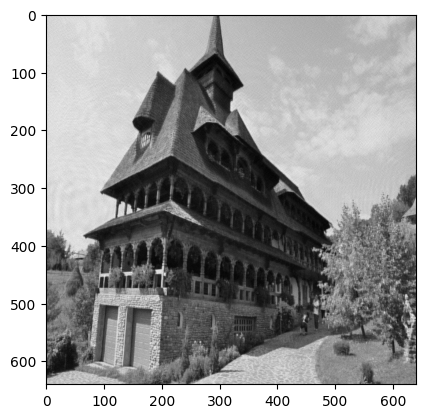

In [12]:
import time
true = x_test[21:26]#load propagated ones
#accuire hologram itself
start_time = time.time()
input=PropagationLayer(true,mode="input")
start_time2 = time.time()
output=model(input)#predicted hologram
end_time = time.time()
inference_time1 = (end_time - start_time)/(true.shape[0])
inference_time2 = (end_time - start_time2)/(true.shape[0])
print(f"Inference + data prep for each image: {inference_time1} seconds")
print(f"Inference time  for each image: {inference_time2} seconds")
print(f"total inference:{(end_time - start_time)}")
reconstructed=PropagationLayer(output,mode="output")#make it final output
true=tf.cast(true,dtype='float32')
output=tf.cast(output,dtype='float32')

def psnr(y_true, y_pred):
    y_true = (y_true - K.min(y_true)) / (K.max(y_true) - K.min(y_true))
    y_pred = (y_pred - K.min(y_pred)) / (K.max(y_pred) - K.min(y_pred))
    if y_pred.shape[-1] != 1:
            y_pred = tf.expand_dims(y_pred, axis=-1)
    x=tf.image.psnr(y_true,y_pred,max_val=1.0)
    return x

psnr_values=psnr(true,reconstructed)
print(psnr_values)
plt.imshow(reconstructed[0],cmap='gray')

Make it ONNX

In [5]:
!python -m tf2onnx.convert --saved-model ImportForONNX --output ./Original_ONNX_OpenVINO/Unet_POH_640.onnx --opset 17

C:\Users\Unknown\AppData\Local\Programs\Python\Python310\lib\runpy.py:126: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2024-01-13 13:00:46,746 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2024-01-13 13:00:47,936 - INFO - Signatures found in model: [serving_default].
2024-01-13 13:00:47,936 - WARNING - '--signature_def' not specified, using first signature: serving_default
2024-01-13 13:00:47,937 - INFO - Output names: ['hologram']
2024-01-13 13:00:48,559 - INFO - Using tensorflow=2.10.0, onnx=1.14.1, tf2onnx=1.13.0/2c1db5
2024-01-13 13:00:48,559 - INFO - Using opset <onnx, 11>
2024-01-13 13:00:48,645 - INFO - Computed 0 values for constant folding
2024-01-13 13:00:48,778 - INFO - Optimizing ONNX model
2024-01-13 13:00:49,161 - INFO - After optimization: BatchNormalization -5 (10->5), Cast -2 (2->0), Con

Also, quantize it

In [6]:
import onnx
from onnxconverter_common import float16
model = onnx.load("./Original_ONNX_OpenVINO/Unet_POH_640.onnx")
model_fp16 = float16.convert_float_to_float16(model)
onnx.save(model_fp16, "./ONNX16bit_8bit/Unet_POH_640_16bit.onnx")